# <a id='toc1_'></a>[Open problems - Single cell perturbations](#toc0_)
## <a id='toc1_1_'></a>[Multiomics data analysis](#toc0_)
### <a id='toc1_1_1_'></a>[by Jalil Nourisa](#toc0_)

## <a id='toc1_2_'></a>[Introduction](#toc0_)
Predictive models are commonly built on transcriptomics data to predict gene expression in novel situations, employing methods like target encoding or gene regulatory networks (GRN). In this approach, the model learns the inter-gene relationships, often encoded by treatment or cell type features, to obtain predictive power. However, the regulatory mechanism of gene expression goes beyond inter-gene interactions and includes processes that are not captured by transcriptomics. For instance, enhancers, crucial in gene regulation, are not reflected in transcriptomic data. Moreover, the interaction of transcriptional factors (TFs) with target genes cannot be fully captured by gene expression data as gene-to-protein translation is not linear. Therefore, further information about the regulatory elements can potentially improve the performance of these models.

Gene expression is controlled by intricate mechanisms, including DNA methylation, histone modification, and transcription factor (TF) activities. Chromatin accessibility offers a comprehensive perspective on these processes, enhancing our understanding of gene regulatory mechanisms, which are fundamental to cellular activities. Single-cell ATAC sequencing (scATAC-seq) reveals insights into open chromatin regions at a single-cell level, facilitating a deeper comprehension of TF-region-gene interactions. Various methods have been developed to integrate gene expression and chromatin accessibility data, aiming to infer a more realistic gene regulatory network (GRN). Once such a GRN model is established, enrichment analysis on treatment samples can be conducted to identify treatment-specific activities of regulatory elements, such as TFs. Utilizing predictive models encoded with this augmented feature space could lead to more effective learning compared to models solely based on gene expression data. Furthermore, chromatin accessibility information can serve as a prior in defining inter-gene relationships within the structure of the models based on transcriptomics data, like variational encoders. In this regard, the coaccessibility of two genes may suggest their potential co-regulation or involvement in a TF-gene relationship.

<div style="text-align: center;">
    <img src="pics/mechanisms_overview.png" alt="Accessibility regulation" class="bg-primary mb-1" width="400px" style="display: block; margin: 0 auto;">
    <p style="text-align: center;"> Overview of chromatin accessibility. Taken from [https://www.sc-best-practices.org/chromatin_accessibility/introduction.html]
</div>

## <a id='toc1_3_'></a>[Objective](#toc0_)
In this notebook, we delve into the multiomics data from the open-problems: single-cell perturbation competition. The provided data is exclusive to the negative control, while our predictions target treatment scenarios involving various perturbation drugs. Despite the variability in ATAC-seq and gene expression across different conditions, we aim to utilize the available data to potentially improve the accuracy of our predictions. We approach this in two ways. First, we construct a GRN using the multiomics data. The GRN could aid in identify key regulatory elements, such as transcription factors (TFs), for each treatment scenario. To do this, we evaluate two state-of-the-art multiomics GRN methods: Scenic+ and CellOracle. Scenic+ analyzes scATAC-seq data to identify regulatory units that show how TFs, regions (enhancers and promotors), and target genes interact, using gene expression values to understand their importance. CellOracle, on the other hand, uses chromatin accessibility data near gene promoters to build a base GRN of TF-target gene pairs, which is then refined using gene expression data. We assess the suitability of these methods in the prediction task of this competition. Secondly, we focus exclusively on chromatin accessibility data to infer possible gene connections. We assume the ATAC-seq data from the negative control is largely relevant to the treatment samples. These inferred gene relationships are then incorporated as a prior in our neural network model (see ?? link), to define sparse patterns of gene-gene relationships. Throughout our analysis, we identify limitations in the provided data and the GRN methods. 

**Table of contents**<a id='toc0_'></a>    
- [Required libraries and external data](#toc2_)    
  - [Installing python libraries](#toc2_1_)    
  - [Installing R libraries](#toc2_2_)    
  - [External data required for this notebook](#toc2_3_)    
- [Imports and initial checks](#toc3_)    
    - [Biomart annotation of genes](#toc3_1_1_)    
    - [Transcript type of genes](#toc3_1_2_)    
  - [Useful functions](#toc3_2_)    
- [Peprocess multiomics data](#toc4_)    
  - [scRNA-seq](#toc4_1_)    
    - [Formatize the data](#toc4_1_1_)    
    - [scRNA-seq data vs de_train](#toc4_1_2_)    
      - [Relevance of the missing genes](#toc4_1_2_1_)    
    - [Subset for one donor and simplify cell types](#toc4_1_3_)    
    - [UMAP plot based on scRNA-seq](#toc4_1_4_)    
  - [scATAC-seq](#toc4_2_)    
    - [Formatize the data](#toc4_2_1_)    
    - [UMAP plot using scATAC-seq](#toc4_2_2_)    
- [GRN using scenic+](#toc5_)    
  - [Topic modeling](#toc5_1_)    
    - [Create cistopic object](#toc5_1_1_)    
    - [Determine number of topics (~6h using 10 cpu)](#toc5_1_2_)    
  - [Accessibility imputation](#toc5_2_)    
  - [Cistarget](#toc5_3_)    
  - [Scenic+ main run](#toc5_4_)    
    - [Merge cistrome](#toc5_4_1_)    
    - [Gene search space + region to gene relationship](#toc5_4_2_)    
    - [TF to gene relationship](#toc5_4_3_)    
    - [Enhancer driven regulons (~10 hours using 10 cpu)](#toc5_4_4_)    
  - [Stats of the regulatory elements](#toc5_5_)    
  - [Relevance of the missing genes](#toc5_6_)    
- [GRN inference using CellOracle](#toc6_)    
  - [Coaccessibility using cicero](#toc6_1_)    
    - [Actual run (~2h for each cell type)](#toc6_1_1_)    
  - [Associate peaks with TSS](#toc6_2_)    
- [Cicero gene activity score](#toc7_)    
- [Coaccessibility for genes](#toc8_)    
  - [Associate peaks with genes](#toc8_1_)    
      - [Format annot to gtf](#toc8_1_1_1_)    
      - [Convert peaks into Grange](#toc8_1_1_2_)    
  - [Sum region-region coaccess within gene body](#toc8_2_)    
  - [Distance between genes](#toc8_3_)    
  - [Check how the gene coaccess correlates to distances](#toc8_4_)    
  - [Stat test coaccess vs distance](#toc8_5_)    
  - [Relevance of missing genes](#toc8_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_5_'></a>[The issue of missing genes](#toc0_)
Considering that most genes in de_train are annotated in Biomart, the missing genes in Scenic+ and CellOracle could be attributed to specific methodological reasons. Scenic+ uses an enrichment analysis to identify regions associated with TF motifs, followed by creating a region-to-gene mapping. This includes regions within 150 kbp of the TSS of target genes. If these regions are not enriched, the corresponding genes are excluded from the GRN. Scenic+ further narrows down the network by filtering out less relevant eRegulons such as those with less than 10 target genes. In CellOracle, the process begins with a coaccessibility analysis to identify region-to-region scores. These regions are then linked to the TSS of genes, within a typical range (like 1000 bp). Low region-region scores or regions not associated with a TSS result in exclusion from the GRN. We conclude that both GRN methods aim to curate a concise GRN with minimal false positive TF-gene links, which results in low coverage on target genes. In addition, they primarily focus on TF-gene interactions, missing out on other regulatory elements like miRNA-target gene interactions. 

We did not explore GRN method that include miRNA, but incorporating these elements could enhance the network. We also could not find a GRN approach that effectively combines chromatin accessibility and gene expression data while covering a large portion of the measured genes. A method achieving this could improve predictions, especially since covering all or most genes, particularly those with high DE values, is essential for the aim of this competition.

In assessing gene-gene coaccess, we calculated scores between regions and associated these with gene bodies for gene-gene scores. Missing genes in this approach might be due to the absence of peaks for certain genomic regions or zero gene-gene scores. 

# <a id='toc2_'></a>[Required libraries and external data](#toc0_)
Following libraries are required for running this notebook. 

## <a id='toc2_1_'></a>[Installing python libraries](#toc0_)

In [38]:
%pip install pybiomart  tqdm  scipy anndata scanpy rpy2

For the libraries of pycisTopic, pycistarget, and scenicplusWe, we clone from githubinstall them.

In [41]:
!git clone https://github.com/aertslab/scenicplus
!cd scenicplus
%pip install .

## <a id='toc2_2_'></a>[Installing R libraries](#toc0_)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("BiocManager")
# Install CRAN packages
install.packages("Gviz")
# Install Bioconductor packages
BiocManager::install("GenomicRanges")
BiocManager::install("rtracklayer")
BiocManager::install("cicero")
BiocManager::install("S4Vectors")

## <a id='toc2_3_'></a>[External data required for this notebook](#toc0_)
In the pipeline of scenic+, the following data is necessary. They are all available on ?? [].

**List of human TFs:**
'utoronto_human_tfs_v_1.01.txt' 

**Regions to motifs ranking**:
'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather'

**Regions to motifs scores**:
'hg38_screen_v10_clust.regions_vs_motifs.scores.feather'

**List of motifs**:
'motifs-v10-nr.hgnc-m0.00001-o0.0.tbl'

# <a id='toc3_'></a>[Imports and initial checks](#toc0_)

In [24]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
tmp_dir = None
work_dir = 'output'
os.makedirs(work_dir, exist_ok=True)

In [5]:
multiome_var_meta = pd.read_csv('../input/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv('input/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

In [3]:
de_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/de_train.parquet')
gene_names_de = de_train.columns[5:]
data = de_train.iloc[:,5:].values

### <a id='toc3_1_1_'></a>[Biomart annotation of genes](#toc0_)

In [34]:
# get the annotations that has highest overlap with the gene names.
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',                        
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',                        
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',      
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}  # evaluated the overlap for each
import pybiomart as pbm
species = 'hsapiens'
host = "http://sep2019.archive.ensembl.org/"   # best one
dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'transcript_biotype'])

annot.columns = ['chr', 'start', 'end', 'gene', 'transcript_type']
annot['width'] = annot.end-annot.start

filter = annot['chr'].str.contains('CHR|GL|JH|MT|KI27')
annot = annot[~filter].reset_index(drop=True)
# change in names
annot.chr = annot.chr.apply(lambda x:f'chr{x}')
annot.drop_duplicates(inplace=True)

In [56]:
print('number of gene in de_train annotated ', annot[annot.gene.isin(gene_names_de)].reset_index(drop=True).gene.unique().shape[0], 
      '/', len(gene_names_de))

number of gene in de_train annotated  17687 / 18211


### <a id='toc3_1_2_'></a>[Transcript type of genes](#toc0_)
Around half of the given genes are protein encoders. This shows that non-protein coding genes might play a significant role in the gene regulation.

In [25]:
annot[annot.gene.isin(gene_names_de)].reset_index(drop=True).transcript_type.value_counts().head()

NameError: name 'annot' is not defined

## <a id='toc3_2_'></a>[Useful functions](#toc0_)

In [13]:
import tqdm
import scipy
import matplotlib.pyplot as plt

def calculate_p_values(genes, data):
    '''
    We conduct a 1-sample Kolmogorov-Smirnov (KS) test to detemine p-values for each given gene versus a uniform set.
    Taken from Antoine Passiemier.
    '''
    p_values = []
    for k in tqdm.tqdm(range(len(genes))):  # Perform test for each gene
        xs = 10 ** (-np.abs(data[:, k]))  # Transform DE values to p-values (assumed to be uniformly-distributed)
        res = scipy.stats.mstats.ks_1samp(xs, scipy.stats.uniform.cdf)  # Kolmogorov-Smirnov test
        p_values.append(res[1])
    p_values = np.asarray(p_values)
    return p_values

de_p_values = calculate_p_values(gene_names_de, data)

def plot_sig_vs_all_genes(target_p_values, name='Missing genes'):
    '''
    Plot the distribution of log p-values obtained from ks_1samp test for a set of given genes versus de_train genes.
    '''
    significance_threshold = 0.001/len(gene_names_de)  # Arbitrary cutoff
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    plt.hist(np.log10(de_p_values), bins=1000, density=True, alpha=0.55, label='All genes', color='navy')
    plt.hist(np.log10(target_p_values), bins=1000, density=True, alpha=0.55, label=name, color='goldenrod')
    plt.axvline(x=np.log10(significance_threshold), linestyle='--', color='black', label='Significance threshold')
    plt.xlabel('Kolmogorov-Smirnov log (p-value)')
    plt.ylabel('Gene density')
    ax.spines[['right', 'top']].set_visible(False)
    plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.xlim([-50, 0])
    plt.show()  

  0%|          | 0/18211 [00:00<?, ?it/s]

100%|██████████| 18211/18211 [00:09<00:00, 1953.41it/s]


<a id="peprocess-multiomics-data"></a>
# <a id='toc4_'></a>[Peprocess multiomics data](#toc0_)
For efficiency in managing computational demands, our analysis focused solely on the ATAC-seq data from donor_0. To optimize resource usage during the Scenic+ computations, which are computationally intensive, we aggregated similar cell types (as identified on UMAP) to create a 'dummy' cell type. This strategy was adopted primarily to assess the overall suitability of the method, ensuring we could effectively gauge its performance without overextending computational resources. This preliminary approach allows for a more manageable evaluation of Scenic+'s applicability to our data, providing a foundation for further, more detailed analysis if deemed appropriate.

In [ ]:
agg_type = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+'] # to be used for scenic+ pipeline

## <a id='toc4_1_'></a>[scRNA-seq](#toc0_)
We use provided normalized values as X and store the counts in the layers.

### <a id='toc4_1_1_'></a>[Formatize the data](#toc0_)

In [37]:
from scipy.sparse import csr_matrix
import anndata

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [38]:
adata = anndata.AnnData(X=mrna_sparse_n, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns),
                layers={'counts':mrna_sparse_raw}
                )
adata.shape

(25551, 22787)

In [40]:
adata.write('output/scRNA/adata.h5ad')

### <a id='toc4_1_2_'></a>[scRNA-seq data vs de_train](#toc0_)
Only 15580 genes out of 18211 genes shared between these two datasets, missing 2631 genes.

In [26]:
adata = anndata.read('output/scRNA/adata.h5ad')
gene_names = adata.var.index
shared_genes = np.intersect1d(gene_names, gene_names_de)
print(f'# of genes in de_train: {len(gene_names_de)},\n of which also in multiomics data: {len(shared_genes)}')

# of genes in de_train: 18211,
 of which also in multiomics data: 15580


#### <a id='toc4_1_2_1_'></a>[Relevance of the missing genes](#toc0_)
We show that the 2631 missing genes missing show equal or more important contributions in the DE values compared to the rest of the genes.

In [6]:
missing_genes_rna = np.setdiff1d(gene_names_de, shared_genes)
de_train_mgs = de_train.loc[:,de_train.columns.isin(missing_genes_rna)]
data_msg = de_train_mgs.values

In [35]:
print(f'mean DE value: all genes {np.mean(data.ravel())}, missing genes: {np.mean(data_msg.ravel())}')
print(f'std DE value: all genes {np.std(data.ravel())}, missing genes: {np.std(data_msg.ravel())}')
print(f'median DE value: all genes {np.median(data.ravel())}, missing genes: {np.median(data_msg.ravel())}')

mean DE value: all genes 0.323305649216879, missing genes: 0.5976097040996542
std DE value: all genes 2.3690969724965405, missing genes: 2.756783610107228
median DE value: all genes 0.061436002336236153, missing genes: 0.1089661624184828


In [7]:
# P values for the missing genes
de_msg_p_values = calculate_p_values(missing_genes_rna, data_msg)

  0%|          | 0/2631 [00:00<?, ?it/s]

100%|██████████| 2631/2631 [00:01<00:00, 2001.06it/s]


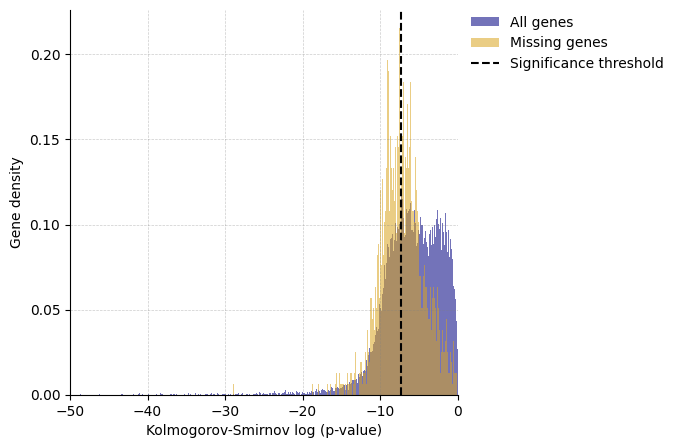

In [14]:
plot_sig_vs_all_genes(de_msg_p_values)

### <a id='toc4_1_3_'></a>[Subset for one donor and simplify cell types](#toc0_)

In [51]:
adata = adata[adata.obs.donor_id=='donor_0',:]

In [55]:
# adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['agg_type'])
adata.obs.loc[adata.obs.cell_type.isin(agg_type), 'cell_type'] = 'agg_type'
adata.write('output/scRNA/adata_donor_0.h5ad')

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### <a id='toc4_1_4_'></a>[UMAP plot based on scRNA-seq](#toc0_)
We first plot the UMAP for all donors and individual cell types. Then, we plot the same graph for donor_0 and aggregated cell types.

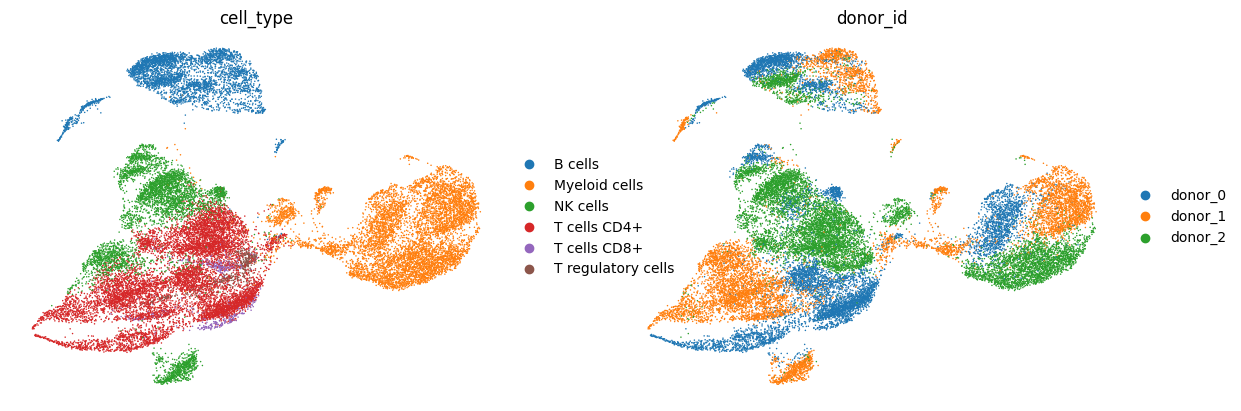

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type', 'donor_id'], frameon=False)

As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

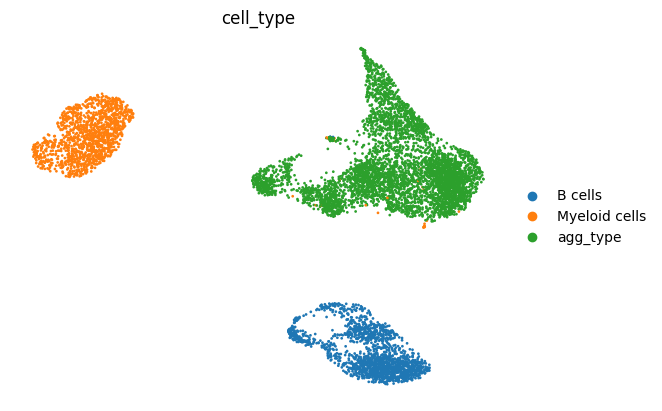

In [56]:
# plot for donor_0 and aggregaed cell types.
import warnings
adata = anndata.read('output/scRNA/adata_donor_0.h5ad')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type'], frameon=False)
adata.write('output/scRNA/adata_donor_0.h5ad')

## <a id='toc4_2_'></a>[scATAC-seq](#toc0_)

In [2]:
import pandas as pd
import os
import anndata
import scanpy as sc
from scipy.sparse import csr_matrix

work_dir = 'output'
os.makedirs(f'{work_dir}/scATAC', exist_ok=True)

### <a id='toc4_2_1_'></a>[Formatize the data](#toc0_)

In [4]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
del multiome_train

In [6]:
# make adata for each donor and save
donor_id = 'donor_0'
obs_ids_donor = multiome_obs_meta[multiome_obs_meta['donor_id']==donor_id]['obs_id'].values 
df_peaks_donor = df_peaks[df_peaks['obs_id'].isin(obs_ids_donor)].reset_index(drop=True)
def extract_count(count='count'):
    df_peaks_table = df_peaks_donor.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
df_peaks_table_n = extract_count(count='normalized_count')
# create adata
X = csr_matrix(df_peaks_table.values)
X_norm = csr_matrix(df_peaks_table_n.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
del df_peaks_donor
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata = anndata.AnnData(X=X, obs=obs, var=var, layers={'x_norm':X_norm})
print('adata is created')
# save
adata.write(f'output/scATAC/adata_{donor_id}.h5ad')
print('adata saved')

### <a id='toc4_2_2_'></a>[UMAP plot using scATAC-seq](#toc0_)
We use agg cell types for scenic+ only. For the remaining methods, we use individual cell types. We frist plot UMAP for all donors and individual cell types. Then, we plot the same graph for donor_0 and aggregated cell types.

In [33]:
donor_id = 'donor_0'
adata = anndata.read_h5ad(f'output/scATAC/adata_{donor_id}.h5ad')

/root/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


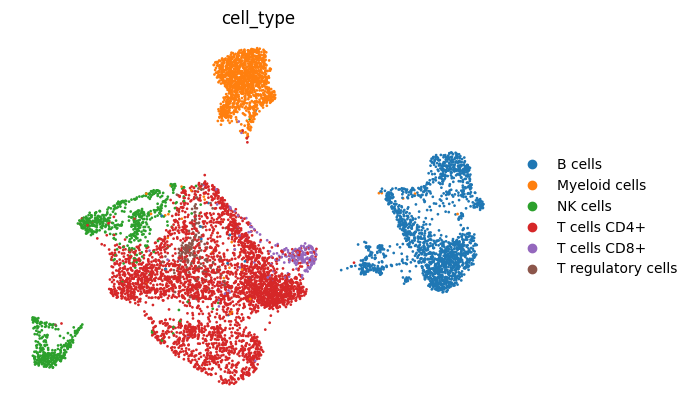

In [35]:
adata.X = adata.layers['x_norm']
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type'], frameon=False)

Similar to UMAP with the RNA data, We see two cell types of T cells CD8+ and T regulatory cells are somewhat blended with T cells CD4+.

/root/anaconda3/envs/scenicplus/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/anaconda3/envs/scenicplus/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/anaconda3/envs/scenicplus/lib/python3.8/site-packages/umap/distances.py:

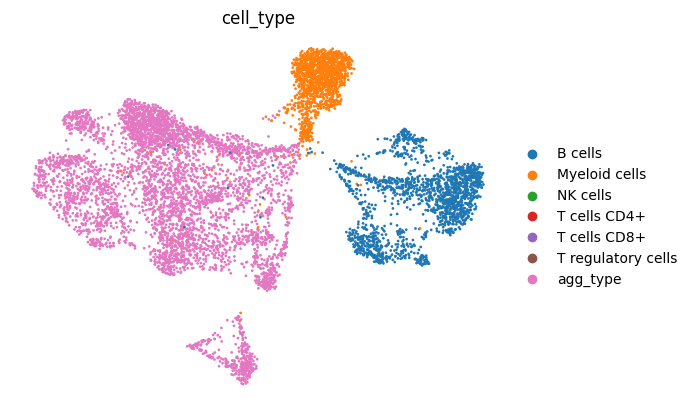

In [24]:
# now lets plot for agg cell type
adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['agg_type'])
adata.obs.loc[adata.obs.cell_type.isin(agg_type), 'cell_type'] = 'agg_type'
adata.X = adata.layers['x_norm']
sc.pp.pca(adata, n_comps=100)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=100)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type'], frameon=False)

# <a id='toc5_'></a>[GRN using scenic+](#toc0_)
We employed the Scenic+ pipeline for GRN inference using integrated scRNA-seq and scATAC-seq data. The Scenic+ pipeline includes these steps:

1) Topic Modeling: Calculation of topics, which are coaccessibility regions, resulting in region-topic association scores.

2) Accessibility Imputation: Binarization of region-topic scores, grouping regions for each topic. This includes running differentially accessible regions across cell types and imputing access data. Notably, the average missingness in single cells drops from ~96% to ~40% after imputation, highlighting a significant source of uncertainty.

3) CisTarget: Determination of enriched motifs for each topic and differentially enriched motifs for each cell type, yielding enriched motifs and their associated genes.

4) Run Scenic+: Calculation of region-to-gene and TF to gene relationships using regression models. This step assesses the importance of regions and TFs for target genes, using imputed region counts, which could introduce errors. After calculating importance scores, only regions enriched for TF motifs are included. The pipeline then creates TF-regions-genes triples named eRegulons, resulting in a curated list of TFs, regions, and target genes.

The Scenic+ pipeline followed is based on the standard protocol as outlined in https://scenicplus.readthedocs.io/en/latest/tutorials.html.

## <a id='toc5_1_'></a>[Topic modeling](#toc0_)

In [9]:
import anndata
donor_id = 'donor_0'
adata = anndata.read_h5ad(f'output/scATAC/adata_{donor_id}.h5ad')
adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['agg_type'])
adata.obs.loc[adata.obs.cell_type.isin(agg_type), 'cell_type'] = 'agg_type'

In [10]:
adata.obs.cell_type.values.unique()

['B cells', 'agg_type', 'Myeloid cells']
Categories (7, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'agg_type']

### <a id='toc5_1_1_'></a>[Create cistopic object](#toc0_)

In [12]:
# format adata to have location*obs
adata_t = adata.T
adata_t.X = adata_t.X.astype(int)

In [ ]:
from pycisTopic.cistopic_class import create_cistopic_object
path_to_blacklist= '../scenicplus/data/hg38-blacklist.v2.bed'
cistopic_obj = create_cistopic_object(
                            fragment_matrix=adata_t.X,
                            cell_names = adata_t.var.index,
                            region_names = adata_t.obs.index,
                            path_to_blacklist=path_to_blacklist,
                            project=donor_id,
                            min_frag = 10,
                            min_cell = 1,
                            split_pattern='___'
                            )
cistopic_obj.add_cell_data(adata_t.var)

2023-11-16 10:52:22,052 cisTopic     INFO     Removing blacklisted regions


2023-11-16 10:52:22,596 cisTopic     INFO     Creating CistopicObject
2023-11-16 10:52:23,411 cisTopic     INFO     Done!


In [ ]:
import pickle, os
work_dir = 'output'
pickle.dump(cistopic_obj,  open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

### <a id='toc5_1_2_'></a>[Determine number of topics (~6h using 10 cpu)](#toc0_)

In [ ]:
!python scripts/compute_topic_number.py

2023-11-15 22:59:48,237	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(run_cgs_model pid=60380) 2023-11-15 22:59:50,278 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=60373) 2023-11-15 23:00:07,423 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=60373) 2023-11-15 22:59:50,366 cisTopic     INFO     Running model with 10 topics [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=60380) 2023-11-15 23:00:14,236 cisTopic     INFO     Model with 16 topics done!
(run_cgs_model pid=60374) 2023-11-15 23:00:30,791 cisTopic     INFO     Model with 32 topics done!


Columns ['cell_type'] will be overwritten


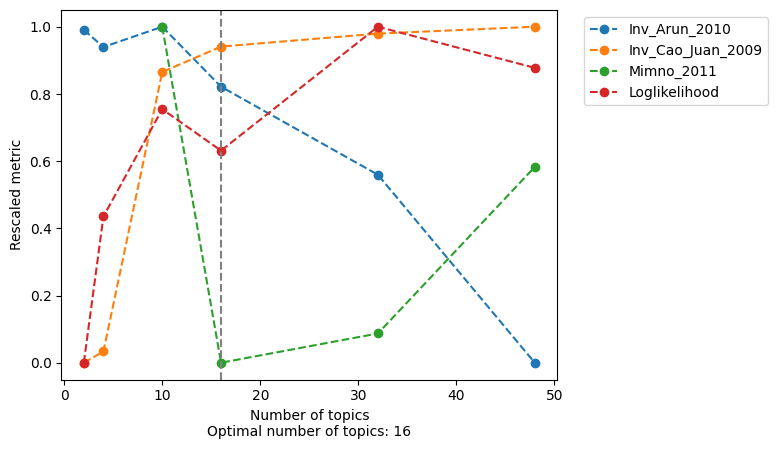

In [13]:
import pickle, os
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
cistopic_obj.add_cell_data(adata_t.var) # to fix the nan issue of cell type
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16, 
                       return_model=True, 
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2023-12-04 14:58:18,330 cisTopic     INFO     Running UMAP


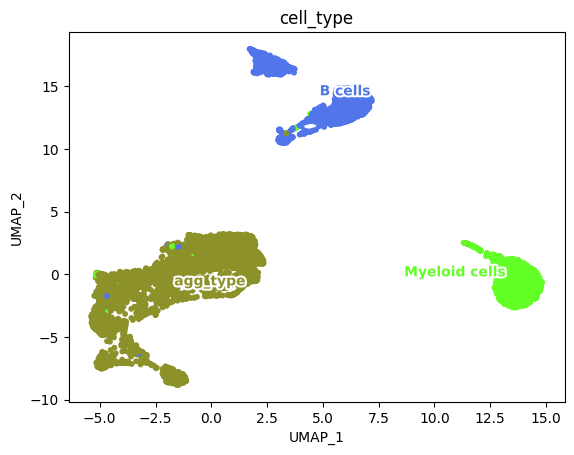

In [14]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target='cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['cell_type'])

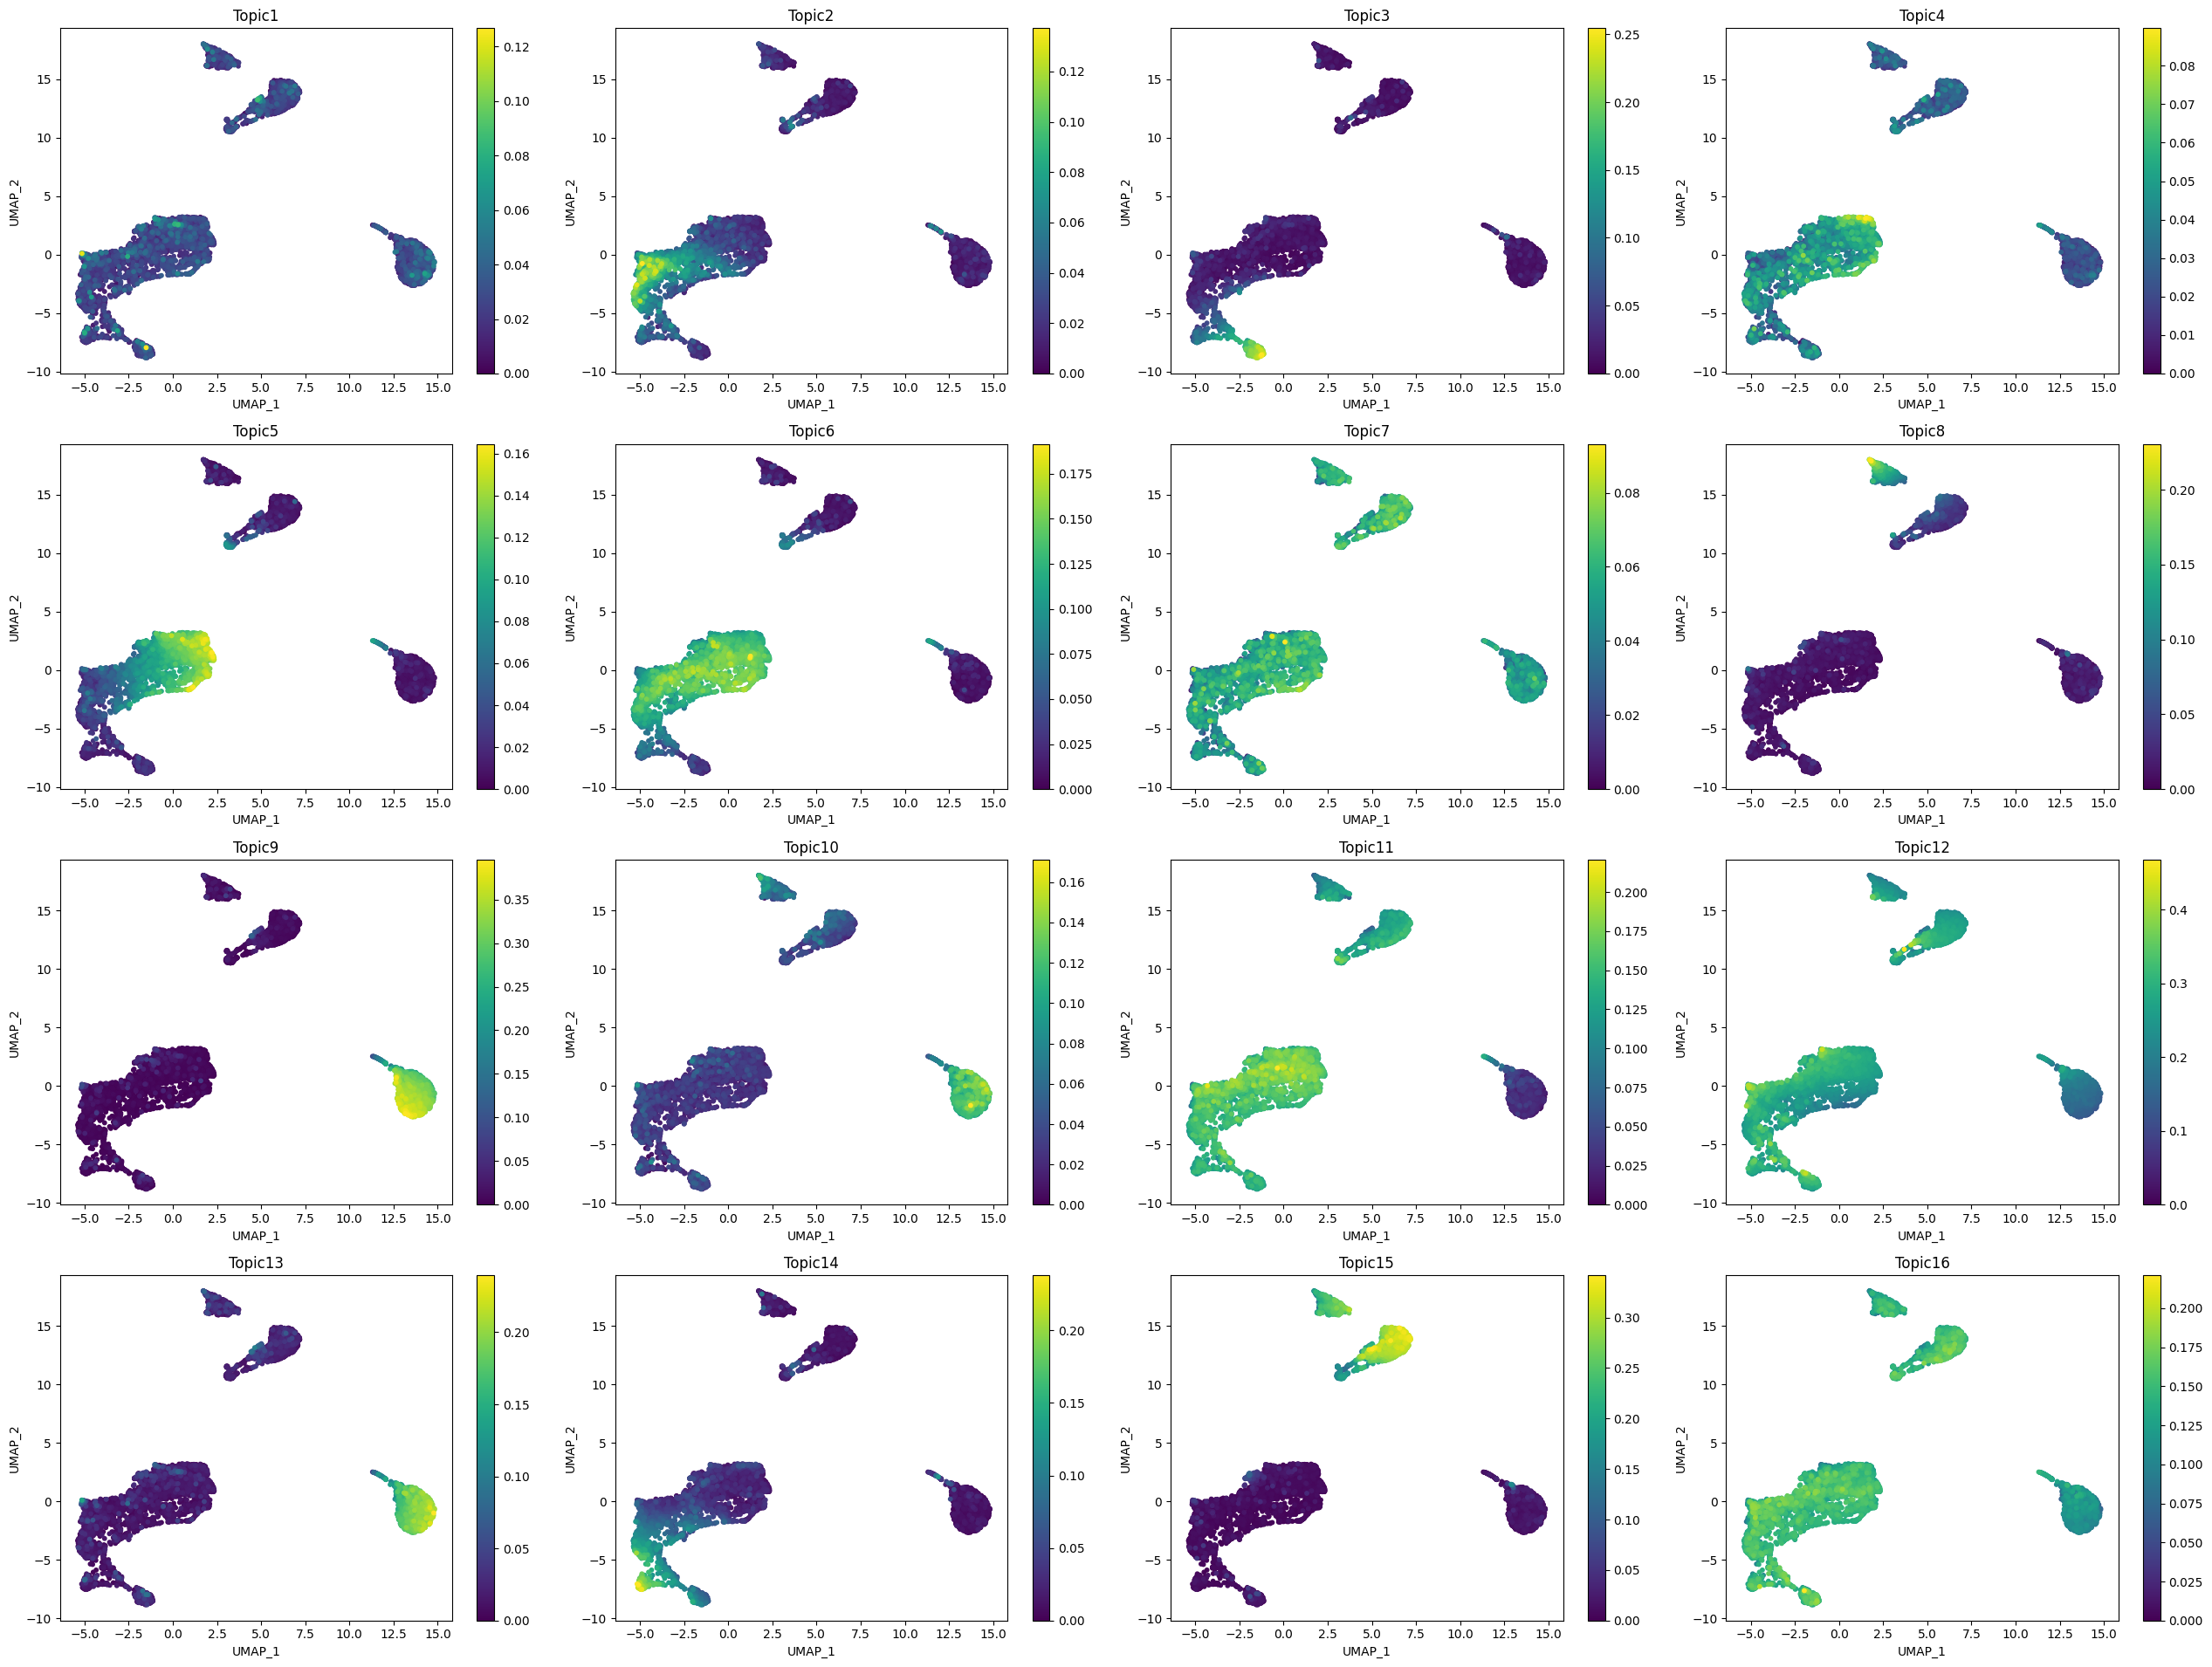

In [15]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

## <a id='toc5_2_'></a>[Accessibility imputation](#toc0_)

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu') #puts regions into topics
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [ ]:
from pycisTopic.diff_features import impute_accessibility, normalize_scores, find_highly_variable_features, find_diff_features
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='cell_type', var_features=variable_regions)

2023-11-16 15:07:02,501 cisTopic     INFO     Imputing region accessibility
2023-11-16 15:07:02,503 cisTopic     INFO     Impute region accessibility for regions 0-20000
2023-11-16 15:07:03,440 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2023-11-16 15:07:04,363 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2023-11-16 15:07:05,242 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2023-11-16 15:07:06,152 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2023-11-16 15:07:07,188 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2023-11-16 15:07:08,083 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2023-11-16 15:07:08,676 cisTopic     INFO     Done!
2023-11-16 15:07:08,684 cisTopic     INFO     Normalizing imputed data
2023-11-16 15:07:13,101 cisTopic     INFO     Done!
2023-11-16 15:07:13,116 cisTopic     INFO     Calculating mean

<Figure size 640x480 with 0 Axes>

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

## <a id='toc5_3_'></a>[Cistarget](#toc0_)

In [1]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [ ]:
# these datasets are publicly available
rankings_db = os.path.join('../scenicplus/data/', 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join('../scenicplus/data/', 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join('../scenicplus/data/', 'motifs-v10-nr.hgnc-m0.00001-o0.0.tbl')

In [ ]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'scATAC/motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 40,
    _temp_dir = None,
    annotation_version = 'v10nr_clust',
    )

## <a id='toc5_4_'></a>[Scenic+ main run](#toc0_)

In [1]:
import dill
import scanpy as sc
import os

adata = sc.read_h5ad('./output/scRNA/adata_donor_0.h5ad')
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'scATAC/motifs/menr.pkl'), 'rb'))

In [ ]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    bc_transform_func = lambda x: f'{x}___donor_0' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

### <a id='toc5_4_1_'></a>[Merge cistrome](#toc0_)
For each topic, we get the enriched motifs, pull out their associated regions, and combined it in one df for each TF. 

In [ ]:
from scenicplus.cistromes import merge_cistromes

merge_cistromes(scplus_obj)
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
            dill.dump(scplus_obj, f, protocol = -1)

### <a id='toc5_4_2_'></a>[Gene search space + region to gene relationship](#toc0_)
The method identifies the relevant regions from the TSS of a gene, spanning a range from -10 to +10 bp up to a distance of 150,000 bp. This process involves determining which regions are significant within this specified range.

For the region-to-gene relationship:

**Regression Model**: it fits a regression model to understand the relationship between regions and genes. This model helps in extracting the importance of various features (regions) in relation to the target gene.

**Correlation Analysis**: it conducts correlation analysis to determine the signs of the relationships. This analysis is crucial for understanding the nature (positive or negative) of the influence that regions have on the target genes.

The imputed region accessibility data are utilized in these regression models, providing a basis for understanding how different genomic regions might influence gene expression.

In [ ]:
from scenicplus.enhancer_to_gene import get_search_space, calculate_regions_to_genes_relationships
biomart_host = "http://sep2019.archive.ensembl.org/" 
species='hsapiens'
assembly='hg38'
upstream = [1000, 150000]
downstream = [1000, 150000]
get_search_space(scplus_obj,
                     biomart_host = biomart_host,
                     species = species,
                     assembly = assembly, 
                     upstream = upstream,
                     downstream = downstream) 
calculate_regions_to_genes_relationships(scplus_obj, 
                        ray_n_cpu = 10, 
                        _temp_dir = None,
                        importance_scoring_method = 'GBM')

In [12]:
print('number of genes in gene space: ',scplus_obj.uns['search_space'].Gene.unique().shape)
print('number of genes in region-to-gene: ', scplus_obj.uns['region_to_gene'].target.unique().shape)

number of genes in gene space:  (19013,)
number of genes in region-to-gene:  (15242,)


### <a id='toc5_4_3_'></a>[TF to gene relationship](#toc0_)
Similar to the previous step, the method uses regression models to map TF (in their gene format) to target genes. This step includes all TFs and all genes (unnecessary as it removes most of them in the next step when considering enriched motifs). 

In [ ]:
from scenicplus.TF_to_gene import calculate_TFs_to_genes_relationships
calculate_TFs_to_genes_relationships(scplus_obj, 
                        tf_file = './output/utoronto_human_tfs_v_1.01.txt',
                        ray_n_cpu = 10, 
                        method = 'GBM',
                        _temp_dir = None,
                        key= 'TF2G_adj')

In [34]:
print('number of TFs in TF2G_adj: ', scplus_obj.uns['TF2G_adj'].TF.unique().shape)
print('number of genes in TF2G_adj: ', scplus_obj.uns['TF2G_adj'].target.unique().shape)

number of TFs in TF2G_adj:  (1269,)
number of genes in TF2G_adj:  (22726,)


### <a id='toc5_4_4_'></a>[Enhancer driven regulons (~10 hours using 10 cpu)](#toc0_)
By having the importane of TFs to genes and regions to genes, in the folowing step, we also consider enriched regions and a few more processes to create eRegulons, which constains a set of TFs, regions, and targets genes.

Since this process takes a very long time, we did not use scenic+ wrapper to run all the steps but rather to run the individually. 

We did not fully understand the exact methodologies behind each individual methods in the following section. We encourage the readers to look at their documentation on scenic+.

In [ ]:
from scenicplus.grn_builder.gsea_approach import *
from scenicplus.utils import *
from scenicplus.eregulon_enrichment import *
n_cpu = 10
_temp_dir = None
region_ranking = None
gene_ranking = None
calculate_TF_eGRN_correlation = True
calculate_DEGs_DARs = True
variable = ['GEX_celltype']
save_path = f'output/scenicplus/' 

scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))
# create a GRN by connecting the previous steps with enrichment analysis
build_grn(scplus_obj,
            min_target_genes = 10,
            adj_pval_thr = 1,
            min_regions_per_gene = 0,
            quantiles = (0.85, 0.90, 0.95),
            top_n_regionTogenes_per_gene = (5, 10, 15),
            top_n_regionTogenes_per_region = (),
            binarize_using_basc = True,
            rho_dichotomize_tf2g = True,
            rho_dichotomize_r2g = True,
            rho_dichotomize_eregulon = True,
            rho_threshold = 0.05,
            keep_extended_motif_annot = True,
            merge_eRegulons = True, 
            order_regions_to_genes_by = 'importance',
            order_TFs_to_genes_by = 'importance',
            key_added = 'eRegulons',
            cistromes_key = 'Unfiltered',
            disable_tqdm = False, 
            ray_n_cpu = n_cpu,
            _temp_dir = _temp_dir)
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
    dill.dump(scplus_obj, f, protocol = -1)
print('------ saved stage 1 --------- ')
print('Formatting eGRNs')
format_egrns(scplus_obj,
                eregulons_key = 'eRegulons',
                TF2G_key = 'TF2G_adj',
                key_added = 'eRegulon_metadata')

print('Converting eGRNs to signatures')
get_eRegulons_as_signatures(scplus_obj,
                                eRegulon_metadata_key='eRegulon_metadata', 
                                key_added='eRegulon_signatures')

print('Calculating eGRNs AUC')
if region_ranking is None:
    print('Calculating region ranking')
    region_ranking = make_rankings(scplus_obj, target='region')
    with open(os.path.join(save_path,'region_ranking.pkl'), 'wb') as f:
        dill.dump(region_ranking, f, protocol = -1)
print('Calculating eGRNs region based AUC')
score_eRegulons(scplus_obj,
        ranking = region_ranking,
        eRegulon_signatures_key = 'eRegulon_signatures',
        key_added = 'eRegulon_AUC', 
        enrichment_type= 'region',
        auc_threshold = 0.05,
        normalize = False,
        n_cpu = n_cpu)
if gene_ranking is None:
    print('Calculating gene ranking')
    gene_ranking = make_rankings(scplus_obj, target='gene')
    with open(os.path.join(save_path,'gene_ranking.pkl'), 'wb') as f:
        dill.dump(gene_ranking, f, protocol = -1)
print('Calculating eGRNs gene based AUC')
score_eRegulons(scplus_obj,
        gene_ranking,
        eRegulon_signatures_key = 'eRegulon_signatures',
        key_added = 'eRegulon_AUC', 
        enrichment_type = 'gene',
        auc_threshold = 0.05,
        normalize= False,
        n_cpu = n_cpu)
print('------ saved stage 2 --------- ')
print('Calculating TF-eGRNs AUC correlation')
for var in variable:
    from scenicplus.cistromes import *
    generate_pseudobulks(scplus_obj, 
                        variable = var,
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Gene_based',
                        nr_cells = 5,
                        nr_pseudobulks = 100,
                        seed=555)
    generate_pseudobulks(scplus_obj, 
                                variable = var,
                                auc_key = 'eRegulon_AUC',
                                signature_key = 'Region_based',
                                nr_cells = 5,
                                nr_pseudobulks = 100,
                                seed=555)
    TF_cistrome_correlation(scplus_obj,
                    variable = var, 
                    auc_key = 'eRegulon_AUC',
                    signature_key = 'Gene_based',
                    out_key = var+'_eGRN_gene_based')
    TF_cistrome_correlation(scplus_obj,
                            variable = var, 
                            auc_key = 'eRegulon_AUC',
                            signature_key = 'Region_based',
                            out_key = var+'_eGRN_region_based')
                            
print('Binarizing eGRNs AUC')
binarize_AUC(scplus_obj, 
        auc_key='eRegulon_AUC',
        out_key='eRegulon_AUC_thresholds',
        signature_keys=['Gene_based', 'Region_based'],
        n_cpu=n_cpu)
      
           
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
    dill.dump(scplus_obj, f, protocol = -1)

## <a id='toc5_5_'></a>[Stats of the regulatory elements](#toc0_)
We can see that the remaing regulatory elements resulted from scenic+ pipeline is only a part of the inputs, e.g. 33 left from ~1200 TFs, 7461 genes left from ~22000 genes, and ~25k left ~120k peak regions. 

In [10]:
import dill, os
import numpy as np
scplus_obj = dill.load(open(os.path.join('output', 'scenicplus/scplus_obj.pkl'), 'rb'))

In [2]:
print('eRegulon: ', len(scplus_obj.uns['eRegulons']), 
      ', TFs: ', scplus_obj.uns['eRegulon_metadata'].TF.unique().size,
      ', target genes: ', scplus_obj.uns['eRegulon_metadata'].Gene.unique().size,
      ', target region: ', scplus_obj.uns['eRegulon_metadata'].Region.unique().size) 

eRegulon:  103 , TFs:  33 , target genes:  7461 , target region:  25082


## <a id='toc5_6_'></a>[Relevance of the missing genes](#toc0_)

In [11]:
scenic_genes = scplus_obj.uns['eRegulon_metadata'].Gene.unique()
shared_genes = np.intersect1d(scenic_genes, gene_names_de)
missing_genes_scenic = np.setdiff1d(gene_names_de, shared_genes)
data_scenic = de_train.loc[:, de_train.columns.isin(missing_genes_scenic)].values

In [14]:
print(f'mean DE value: all genes {np.mean(data.ravel())}, target genes: {np.mean(data_target.ravel())}')
print(f'std DE value: all genes {np.std(data.ravel())}, target genes: {np.std(data_target.ravel())}')
print(f'median DE value: all genes {np.median(data.ravel())}, target genes: {np.median(data_target.ravel())}')

mean DE value: all genes 0.323305649216879, target genes: 0.4789181574571958
std DE value: all genes 2.3690969724965405, target genes: 2.4997379974208336
median DE value: all genes 0.061436002336236153, target genes: 0.09204379821746303


  0%|          | 0/10928 [00:00<?, ?it/s]

100%|██████████| 10928/10928 [00:05<00:00, 2030.48it/s]


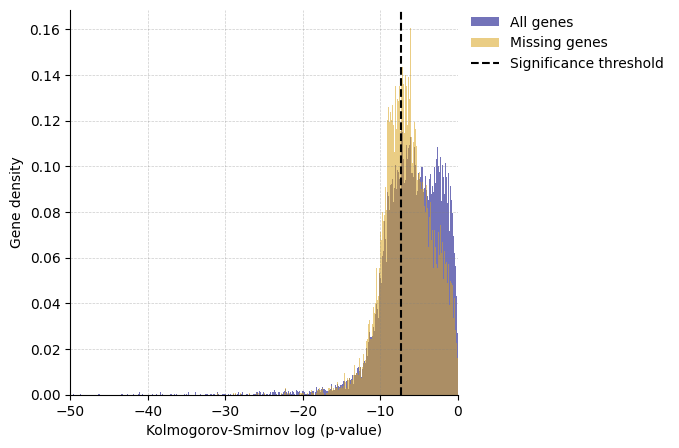

In [15]:
p_values = calculate_p_values(missing_genes_scenic, data_scenic)
plot_sig_vs_all_genes(p_values, name='Missing genes')

# <a id='toc6_'></a>[GRN inference using CellOracle](#toc0_)
The pipeline of celloracle includes these steps:

* Calculate coacc scores between regions: Cicero is used for this, yielding values between -1 and 1 for each pair of regions. 
* Associate regions with gene promoters: Here, peaks are linked with the transcriptional start site (TSS) of genes. This results in coacc scores between the TSS region and other regions. In the original documentation, a threshold, like 0.7, is used to filter less relevant links, forming the base GRN.
* Calculate importance scores using regression models: For each target gene, a regression model (similar to GENIE3) is fitted, obtaining feature importance that describes the TF-gene regulation score. This network is then filtered based on the base GRN to remove potential false negatives.
  
We only completed steps 1 and 2 of the pipeline and skipped the rest due to coverage issues with the target genes.

For a detailed description, please refer to the original tutorial by celloracle: https://morris-lab.github.io/CellOracle.documentation/tutorials/index.html

## <a id='toc6_1_'></a>[Coaccessibility using cicero](#toc0_)
Using scATAC-seq data, we obtain coaccessibiluty of the regions using cicero pipeline, provided in https://cole-trapnell-lab.github.io/cicero-release/docs/#constructing-cis-regulatory-networks.

In [115]:
cicero_dir = 'output/cicero'
os.makedirs(cicero_dir, exist_ok=True)

In [25]:
donor_id = 'donor_0'
obs_donor = multiome_obs_meta[multiome_obs_meta['donor_id']==donor_id]
df_peaks_donor = df_peaks[df_peaks['obs_id'].isin(obs_donor['obs_id'].values)].reset_index(drop=True)

In [7]:
CELL_TYPES = multiome_obs_meta.cell_type.unique()

In [26]:
cell_type = CELL_TYPES[0]
obs_donor_cell_type = obs_donor[obs_donor['cell_type']==cell_type]
df_peaks_cell_type = df_peaks[df_peaks['obs_id'].isin(obs_donor_cell_type['obs_id'].values)].reset_index(drop=True)

In [123]:
def format(df):
    df.loc[:, 'location'] = df.location.str.replace(':','_')
    df.loc[:, 'location'] = df.location.str.replace('-','_')
    return  df
df_peaks_cell_type = format(df_peaks_cell_type)

In [124]:
df_peaks_cell_type[['location','obs_id','count']].to_csv(f'output/scATAC/{donor_id}_{cell_type}.txt', sep='\t', header=None, index=False)

In [1]:
%load_ext rpy2.ipython

/root/anaconda3/envs/rpy2/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:83: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded, as we did not manage to load `numpy` in the first place (error: No module named 'numpy').
  warnings.warn('The Python package `pandas` is strongly '


In [27]:
%%R -i donor_id -i cell_type
library(Gviz)
library(GenomicRanges)
library(rtracklayer)
library(cicero)
set.seed(2017)
# get the peaks
cicero_data <- read.table(paste0("output/scATAC/", donor_id, "_", cell_type, ".txt"), sep = "\t", header = FALSE)
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)
# preprocessing
input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")
# reduced dimension and cicero object
umap_coords <- reducedDims(input_cds)$UMAP
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

In [131]:
# Get chromosome sizes (for hg38 here). 
import pandas as pd
import os 
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]

chromsizes = chromsizes[['Chromosome', 'End']]

In [132]:
# check if all chr are found
chrs = df_peaks_cell_type.location.apply(lambda x:x.split('_')[0])
chrs.isin(chromsizes.Chromosome).sum()

935611

### <a id='toc6_1_1_'></a>[Actual run (~2h for each cell type)](#toc0_)

In [133]:
%%R -i chromsizes
conns <- run_cicero(cicero_cds, chromsizes)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  8100"
[1] "Other models: "

Zero or one element in range 
                        5000 
[1] "Models with errors:  0"
[1] "Done"


In [135]:
%%R -i donor_id -i cell_type -i cicero_dir
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(cicero_dir, "/", "all_peaks_", donor_id,"_", cell_type,".csv"))
write.csv(x = conns, file = paste0(cicero_dir, "/", "connections_", donor_id,"_", cell_type,".csv"))

## <a id='toc6_2_'></a>[Associate peaks with TSS](#toc0_)
Each peak is associated with promotors of target genes (+- 1kbp). Celloracle should be installed for this step.

In [28]:
from celloracle import motif_analysis as ma
import pandas as pd
cicero_dir = 'output/cicero/'
donor_id = 'donor_0'
cell_type = 'Myeloid cells'
peaks = pd.read_csv(f"{cicero_dir}/all_peaks_{donor_id}_{cell_type}.csv", index_col=0)
cicero_connections =  pd.read_csv(f"{cicero_dir}/connections_{donor_id}_{cell_type}.csv", index_col=0)

In [ ]:
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38")
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)

# <a id='toc7_'></a>[Cicero gene activity score](#toc0_)
Based on the coaccessible regions, we determine the activities of genes associated with the regions.

In [3]:
%load_ext rpy2

The rpy2 module is not an IPython extension.


In [1]:
donor_id = 'donor_0'
cell_type = 'NK cells'
cicero_dir = 'output/cicero'

In [4]:
%%R -i donor_id -i cell_type
library(Gviz)
library(GenomicRanges)
library(rtracklayer)
library(cicero)
cicero_data <- read.table(paste0("output/scATAC/", donor_id, "_", cell_type, ".txt"), sep = "\t", header = FALSE)
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)
input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R -i cicero_dir -i donor_id -i cell_type
file_path <- paste0(cicero_dir, "/", "connections_", donor_id, "_", cell_type, ".csv")
conns <- read.csv(file_path)

In [10]:
%%R
# download and unzip
temp <- tempfile()
download.file("ftp://ftp.ensembl.org/pub/release-65/gtf/homo_sapiens/Homo_sapiens.GRCh37.65.gtf.gz", temp)
annot <- rtracklayer::readGFF(temp)
unlink(temp)

annot$seqid <- sub("^(\\d+|X|Y)$", "chr\\1", annot$seqid)

# rename some columns to match requirements
annot$chromosome <- annot$seqid
annot$gene <- annot$gene_id
annot$transcript <- annot$transcript_id
annot$symbol <- annot$gene_name
head(annot)

       seqid         source        type  start    end score strand phase
1 GL000213.1 protein_coding        exon 138767 139339    NA      -    NA
2 GL000213.1 protein_coding         CDS 138767 139287    NA      -     0
3 GL000213.1 protein_coding start_codon 139285 139287    NA      -     0
4 GL000213.1 protein_coding        exon 134276 134390    NA      -    NA
5 GL000213.1 protein_coding         CDS 134276 134390    NA      -     1
6 GL000213.1 protein_coding        exon 133943 134116    NA      -    NA
          gene_id   transcript_id exon_number  gene_name   gene_biotype
1 ENSG00000237375 ENST00000327822           1 BX072566.1 protein_coding
2 ENSG00000237375 ENST00000327822           1 BX072566.1 protein_coding
3 ENSG00000237375 ENST00000327822           1 BX072566.1 protein_coding
4 ENSG00000237375 ENST00000327822           2 BX072566.1 protein_coding
5 ENSG00000237375 ENST00000327822           2 BX072566.1 protein_coding
6 ENSG00000237375 ENST00000327822           3 BX072566.1 

versuche URL 'ftp://ftp.ensembl.org/pub/release-65/gtf/homo_sapiens/Homo_sapiens.GRCh37.65.gtf.gz'
Content type 'unknown' length 20654706 bytes (19.7 MB)


In [18]:
%%R 
gene_anno <- annot
#### Add a column for the pData table indicating the gene if a peak is a promoter ####
# Create a gene annotation set that only marks the transcription start sites of 
# the genes. We use this as a proxy for promoters.
# To do this we need the first exon of each transcript
pos <- subset(gene_anno, strand == "+")
pos <- pos[order(pos$start),] 
# remove all but the first exons per transcript
pos <- pos[!duplicated(pos$transcript),] 
# make a 1 base pair marker of the TSS
pos$end <- pos$start + 1 

neg <- subset(gene_anno, strand == "-")
neg <- neg[order(neg$start, decreasing = TRUE),] 
# remove all but the first exons per transcript
neg <- neg[!duplicated(neg$transcript),] 
neg$start <- neg$end - 1

gene_annotation_sub <- rbind(pos, neg)

# Make a subset of the TSS annotation columns containing just the coordinates 
# and the gene name
gene_annotation_sub <- gene_annotation_sub[,c("chromosome", "start", "end", "symbol")]

# Rename the gene symbol column to "gene"
names(gene_annotation_sub)[4] <- "gene"

input_cds <- annotate_cds_by_site(input_cds, gene_annotation_sub)

In [25]:
%%R 
nan_rows <- fData(input_cds)[!is.na(fData(input_cds)$gene), ]
length(unique(nan_rows$gene))

[1] 4598


In [27]:
%%R
#### Generate gene activity scores ####
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns)

# remove any rows/columns with all zeroes
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0, 
                       !Matrix::colSums(unnorm_ga) == 0]

# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)

# if you had two datasets to normalize, you would pass both:
# num_genes should then include all cells from both sets
unnorm_ga2 <- unnorm_ga
cicero_gene_activities <- normalize_gene_activities(list(unnorm_ga, unnorm_ga2), 
                                                    num_genes)

# <a id='toc8_'></a>[Coaccessibility for genes](#toc0_)
**Nature of relationship**:
Coaccess can give us insight about gene interactions where genes are located apart from one another and their interaction is not trivial based on their distance on chromosome. Chromatin looping can bring TFs and enhancers together and transcribe muliple genes simultaneouly. Therefore, following relationships can be expected from coaccessible genes:
1) Coregulation: two genes which share same TFs are transcibed together
2) Regulation: one of the two genes with coaccessibility is a potential TF of another gene (after tranlation to protein)
3) Participation in regulation: two genes with coaccess could be part of same regulation mechanism. Each can potentially take a form TF, target, or enhancer.

## <a id='toc8_1_'></a>[Associate peaks with genes](#toc0_)

In [70]:
import pandas as pd
import numpy as np
if False:# get the peaks
    # read multiomics data 
    multiome_var_meta = pd.read_csv('input/open-problems-single-cell-perturbations/multiome_var_meta.csv')
    multiome_obs_meta = pd.read_csv('../input/open-problems-single-cell-perturbations/multiome_obs_meta.csv')
    multiome_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/multiome_train.parquet')
    # extract only peaks
    peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
    df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
    del multiome_train
    peaks = df_peaks.location.unique()
    np.savetxt('output/peaks.csv', peaks, fmt='%s')
else:
    peaks = np.genfromtxt('output/peaks.csv', dtype=str)
    peaks = pd.DataFrame(peaks, columns=['location'])   

In [1]:
# filter based on genes we have
annot = annot[['chr', 'start', 'end', 'gene', 'strand']]
import pandas as pd

# Filter the annotation data to include only the genes in 'gene_names_de'
annot = annot[annot['gene'].isin(gene_names_de)].reset_index(drop=True)
print(annot.gene.unique().shape)

# check if there are multiple chr for genes
def filter_func(df):
    if df['chr'].unique().shape[0]>1:
        return True
    else:
        return False
gene_to_remove = annot.groupby('gene').apply(filter_func)
gene_to_remove = gene_to_remove[gene_to_remove].index
print(gene_to_remove)
annot = annot[~annot.gene.isin(gene_to_remove)]

(17687,)
Index(['SNORD63'], dtype='object', name='gene')


#### <a id='toc8_1_1_1_'></a>[Format annot to gtf](#toc0_)

In [2]:
# get annotation
import pybiomart as pbm
species = 'hsapiens'
host = "http://sep2019.archive.ensembl.org/" 
dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'transcript_start', 'transcript_end', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])

annot.columns = ['chr', 'start', 'end', 'transcript_start', 'transcript_end', 'tss', 'strand', 'gene', 'transcript_type']
annot['width'] = annot.end-annot.start
annot['transcript_width'] = annot.transcript_end-annot.transcript_start

filter = annot['chr'].str.contains('CHR|GL|JH|MT|KI27')
annot = annot[~filter].reset_index(drop=True)


In [3]:
# Define the GTF columns
gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
# Create a DataFrame to hold the GTF data
gtf_df = pd.DataFrame(columns=gtf_columns)
# Fill in the GTF DataFrame
gtf_df['seqname'] = annot['chr']
gtf_df['source'] = 'your_source'  # Replace with the appropriate source name
gtf_df['feature'] = 'gene'  # Assuming all features are genes
gtf_df['start'] = annot['start']
gtf_df['end'] = annot['end']
gtf_df['score'] = '.'  # If no score, use '.'
gtf_df['strand'] = annot['strand']  # If strand information is not available, use '.'
gtf_df['frame'] = '.'  # If frame information is not available, use '.'
gtf_df['attribute'] = 'gene_id "' + annot['gene'] + '";'  # Construct the attribute field
def format_strand(x):
    if x==1:
        return '+'
    elif x==-1:
        return '-'
    else:
        return '*'
gtf_df.strand = gtf_df.strand.apply(format_strand)
gtf_df
# # Save the DataFrame as a GTF file
gtf_df.to_csv('output/annotations.gtf', sep='\t', index=False, header=False, quoting=3)

#### <a id='toc8_1_1_2_'></a>[Convert peaks into Grange](#toc0_)

In [57]:
# reformat peaks
peaks[['chr', 'start_end']] = peaks['location'].str.split(':', expand=True)
peaks[['start', 'end']] = peaks['start_end'].str.split('-', expand=True)
peaks = peaks.drop(columns=['start_end'])
peaks['start'] = pd.to_numeric(peaks['start'])
peaks['end'] = pd.to_numeric(peaks['end'])
peaks['width'] = peaks.end-peaks.start
filter = peaks['chr'].str.contains('chr')
peaks = peaks[filter].reset_index(drop=True)

In [3]:
seqnames = peaks.chr.values
starts = peaks.start.values
ends = peaks.end.values

In [4]:
%load_ext rpy2.ipython

In [25]:
%%R -i seqnames -i starts -i ends -o peaks_genes
library(GenomicRanges)
library(rtracklayer)
library(S4Vectors)
# Create a GRanges object
granges_peaks <- GRanges(seqnames = seqnames,
                         ranges = IRanges(start = starts, end = ends),
                         strand = rep("*", length(seqnames)))


annot <- rtracklayer::import('output/annotations.gtf')
nearest_genes <- distanceToNearest(granges_peaks, annot)

nearest_gene_ids <- subjectHits(nearest_genes)

# Get the gene information from 'annot' based on these IDs
nearest_gene_info <- annot[nearest_gene_ids]

# Convert the gene information and peaks to data frames
nearest_gene_info_df <- as.data.frame(nearest_gene_info)
gene_names <- nearest_gene_info_df$gene_id
peaks_df <- as.data.frame(granges_peaks)

# Extract the distance information
distances <- mcols(nearest_genes)$distance

# Combine the data frames and include the distance
peaks_genes <- cbind(peaks_df, gene=gene_names, distance = distances)

In [15]:
peaks_genes = peaks_genes.rename(columns={'seqnames':'chr'})
peaks_genes['peak'] = peaks_genes.apply(lambda row: f"{row['chr']}_{row['start']}_{row['end']}", axis=1)
peaks_genes

In [16]:
peaks_genes.to_csv('output/peaks_genes.csv')

In [28]:
# format. 78000 peaks are annotated with a gene
peaks_genes = peaks_genes[peaks_genes.distance==0].reset_index(drop=True)
peaks_genes = peaks_genes[['chr', 'start', 'end', 'gene']]

In [35]:
peaks_genes.to_csv('output/peaks_genes.csv')

In [23]:
import numpy  as np
import pandas as pd
from op_sc_tools.variables import de_train
CELL_TYPES = de_train.cell_type.unique()
peaks_genes = pd.read_csv('output/peaks_genes.csv',index_col=0)

In [111]:
# get conn and process it
cell_type = CELL_TYPES[5]
donor = 'donor_0'
conn = pd.read_csv(f'output/cicero/connections_{donor}_{cell_type}.csv', index_col=0)
# drop zero coaccess
conn = conn[conn.coaccess!=0].reset_index(drop=True)
# remove na 
conn = conn[~conn.coaccess.isna()]
# remove dup
genes_array = conn[['Peak1', 'Peak2']].to_numpy()
sorted_genes_array = np.sort(genes_array, axis=1)
conn[['Peak1', 'Peak2']] = sorted_genes_array
conn = conn.drop_duplicates()
# filter to only have those peaks present in peaks_genes
conn = conn[conn.Peak1.isin(peaks_genes.peak)]
conn = conn[conn.Peak2.isin(peaks_genes.peak)].reset_index(drop=True)

In [112]:
# map peak to gene
peak_to_gene_map = dict(zip(peaks_genes['peak'].values, peaks_genes['gene'].values))
vectorized_map_fun = np.vectorize(lambda peak: peak_to_gene_map.get(peak, None))
conn['Peak1'] = vectorized_map_fun(conn['Peak1'].values)
conn['Peak2'] = vectorized_map_fun(conn['Peak2'].values)
conn = conn.rename(columns={'Peak1':'gene1', 'Peak2':'gene2'})
# remove dup
conn = conn[conn['gene1'] != conn['gene2']]

## <a id='toc8_2_'></a>[Sum region-region coaccess within gene body](#toc0_)

In [ ]:
conn_sum = conn.groupby(['gene1', 'gene2'])['coaccess'].sum().reset_index().sort_values('coaccess').reset_index(drop=True)


In [113]:
print(f'# genes {len(conn_sum.gene1.unique())}, mean coaccess {conn_sum.coaccess.mean()}')

# genes 11405, mean coaccess 0.04734233352775506


In [114]:
import os
os.makedirs('output/coaccess', exist_ok=True)
conn_sum.to_csv(f'output/coaccess/{donor}_{cell_type}.csv')

## <a id='toc8_3_'></a>[Distance between genes](#toc0_)
We calculate distance between genes and evaluate how coaccessibility correlates with distance.

In [49]:
# we only consider start for distance calculation
# check for multiple start points
def filter_func(df):
    if df['start'].unique().shape[0]>1:
        return True
    else:
        return False
gene_to_remove = annot.groupby('gene').apply(filter_func)
gene_to_remove = gene_to_remove[gene_to_remove].index
print(gene_to_remove)
annot = annot[~annot.gene.isin(gene_to_remove)]

annot_start = annot[['chr', 'start', 'gene']]

Index(['ABCF2', 'AHRR', 'ALG1L9P', 'ARMCX5-GPRASP2', 'ATXN7', 'CYB561D2',
       'GGT1', 'GOLGA8M', 'HSPA14', 'LINC01238', 'LINC01505', 'PDE11A',
       'POLR2J3', 'POLR2J4', 'RMRP', 'SOD2', 'TBCE', 'TMSB15B'],
      dtype='object', name='gene')


In [50]:
import numpy as np
def group_func(df):
    genes = df.gene.unique()
    starts = []
    for gene in genes:
        df_gene = df[df.gene==gene]
        start_unique = df_gene.start.unique()
        if start_unique.shape[0]>1:
            print('problem here')
        starts.append(start_unique[0])
    starts = np.asarray(starts)
    combined = np.concatenate([genes.reshape(-1,1), starts.reshape(-1,1)], axis=1) 
    return pd.DataFrame(combined, columns=['gene', 'start'])
if 'chr' not in annot.columns:
    annot = annot.reset_index()
annot_start = annot_start.groupby('chr').apply(group_func)

In [58]:
df = annot_start
results = []
# Group by chromosome and calculate distances using NumPy
for chromosome, group in df.groupby('chr'):
    starts = group['start'].values
    genes = group['gene'].values
    
    # Calculate pairwise distances (as a matrix)
    distances = np.abs(starts[:, np.newaxis] - starts)

    # Iterate over the upper triangle of the distance matrix to avoid duplicate pairs and self-pairs
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            results.append({'gene1': genes[i], 'gene2': genes[j], 'distance': distances[i, j]})

# Create a DataFrame from the results
distance_df = pd.DataFrame(results)

In [60]:
distance_df.to_csv('../multiomics/output/distance.csv')

## <a id='toc8_4_'></a>[Check how the gene coaccess correlates to distances](#toc0_)

In [16]:
import pandas as pd
donor = 'donor_0'
cell_type = 'NK cells'
conn_sum = pd.read_csv(f'output/coaccess/{donor}_{cell_type}.csv', index_col=0)
distance_df = pd.read_csv(f'output/distance.csv', index_col=0)

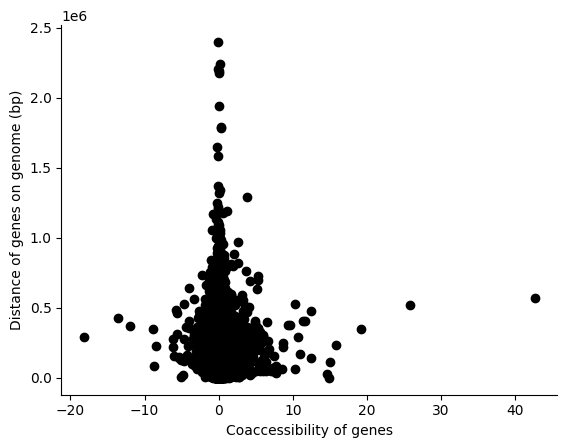

In [23]:
import random
import matplotlib.pyplot as plt
df1 = conn_sum.copy()
df2 = distance_df.copy()
merged_data = pd.merge(df1, df2, on=['gene1', 'gene2'])
plt.scatter(merged_data.coaccess, merged_data.distance, c='black')
# plt.axhline(y=500000, color='r', linestyle='-')
plt.xlabel('Coaccessibility of genes')
plt.ylabel('Distance of genes on genome (bp)')

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## <a id='toc8_5_'></a>[Stat test coaccess vs distance](#toc0_)

In [137]:
import scipy
correlation_coefficient, p_value = scipy.stats.spearmanr(merged_data['coaccess'], merged_data['distance'])
print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")
alpha = 0.05  # Common choice for significance level
if p_value < alpha:
    print("The correlation between coaccess and distance is statistically significant.")
    if correlation_coefficient < 0:
        print("There is a negative correlation, meaning as coaccess increases, distance decreases.")
    else:
        print("There is a positive correlation.")
else:
    print("No significant correlation found between coaccess and distance.")

Correlation Coefficient: -0.04945462223132726
P-value: 7.857861164327092e-26
The correlation between coaccess and distance is statistically significant.
There is a negative correlation, meaning as coaccess increases, distance decreases.


## <a id='toc8_6_'></a>[Relevance of missing genes](#toc0_)

In [45]:
import numpy as np
conn_shared_genes = np.intersect1d(conn_sum.gene1, conn_sum.gene2)
missing_genes_coacc = np.setdiff1d(gene_names_de, conn_shared_genes)
data_coacc = de_train.iloc[:, de_train.columns.isin(missing_genes_coacc)].values
p_values = calculate_p_values(missing_genes_coacc, data_coacc)

100%|██████████| 8019/8019 [00:06<00:00, 1293.06it/s]


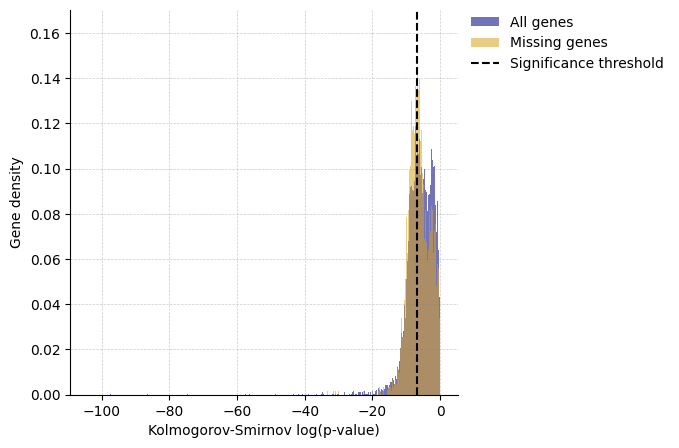

In [46]:
plot_sig_vs_all_genes(p_values)